In [86]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data

In [87]:
#btc options data
df=pd.read_csv('data/btc_data.csv', sep=",", index_col=0)

#df.drop(columns=['Unnamed: 0', 'interest_rate'], inplace=True)


In [88]:
# Convert date column
df['Expiration_Date'] = pd.to_datetime(df['Expiration Date'], format='%d%b%y')



In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1029 entries, 0 to 1029
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   best_bid_amount     1029 non-null   float64       
 1   best_ask_amount     1029 non-null   float64       
 2   bid_iv              1029 non-null   float64       
 3   ask_iv              1029 non-null   float64       
 4   underlying_index    1029 non-null   object        
 5   underlying_price    1029 non-null   float64       
 6   mark_iv             1029 non-null   float64       
 7   best_bid_price      1029 non-null   float64       
 8   best_ask_price      1029 non-null   float64       
 9   open_interest       1029 non-null   float64       
 10  max_price           1029 non-null   float64       
 11  min_price           1029 non-null   float64       
 12  last_price          864 non-null    float64       
 13  asks                1029 non-null   object        
 1

### Black-Scholes model

* Stock Price (S): In cryptocurrency, this would be the current price of the crypto asset.

* Strike Price (K): The price at which the option can be exercised.

* Time to Expiration (T): The remaining life of the option, usually in years.

* Risk-free Rate (r): The rate of return on a risk-free investment, typically treasury bills.

* Volatility (σ): This is where most adjustments for cryptocurrencies will be made, reflecting the asset's price variability.

example

In [90]:
import numpy as np
from scipy.stats import norm

# Parameters
S = 59330.12  # current BTC price
K = 35000     # strike price
T = 0.25      # time to maturity in years
r = 0.01      # risk-free rate
sigma = 1.20  # adjusted annual volatility

# Black-Scholes formulas
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

print(f"The adjusted Black-Scholes call price is: ${call_price:.2f}")


The adjusted Black-Scholes call price is: $27166.22


In [91]:
import numpy as np
from scipy.stats import norm
from datetime import datetime

# Assuming you've loaded your dataset into a DataFrame named `df`
# For this example, let's select one option to price, e.g., the first row in the dataset
option_data = df.iloc[20]

# Parameters extraction
S = option_data['underlying_price']  # Current price of the underlying asset
K = option_data['Strike Price']      # Strike price of the option
# Adjust the date format to match '3MAY24' which is 'd%b%y' without day leading zero and all-caps month
T = (datetime.strptime(option_data['Expiration Date'], '%d%b%y') - datetime.now()).days / 365.25  # Time to maturity in years
r = 0.01  # Assuming a risk-free rate of 1%
sigma = option_data['mark_iv'] / 100  # Implied volatility from the market data

# Adjusting volatility for crypto-specific factors
sigma *= 1.5  # Adjusting by 50% to account for higher volatility

# Black-Scholes formula for call option
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

print(f"The adjusted Black-Scholes call price for the selected option is: ${call_price:.2f}")


The adjusted Black-Scholes call price for the selected option is: $nan


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\3153892223.py:21: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\3153892223.py:22: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


In [92]:
# Convert Expiration Date to datetime and calculate Time to Expiration in years
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])
df['Time to Expiration'] = (df['Expiration Date'] - pd.Timestamp.now()).dt.days / 365

# Use average implied volatility or calculate it if not directly provided
df['Implied Volatility'] = (df['bid_iv'] + df['ask_iv']) / 2 / 100  # converting percentage to decimal


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\434982000.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])


In [93]:
# Example: Using a simple moving average for volatility
df['SMA Volatility'] = df['Implied Volatility'].rolling(window=30).mean()  # 30-day simple moving average


In [94]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """ Calculate the Black-Scholes option price for a call option """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Risk-free rate - As crypto does not have a clear risk-free rate, you may use a proxy like U.S. Treasury rates or a stablecoin yield
risk_free_rate = 0.02  # 2%


In [95]:
# Apply the model to each option in the dataframe
df['BS Price'] = df.apply(lambda x: black_scholes_call(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], risk_free_rate, x['Implied Volatility']), axis=1)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\4222010145.py:5: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\4222010145.py:6: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\4222010145.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [96]:
# Apply the model to each option in the dataframe
df['BS Price_1'] = df.apply(lambda x: black_scholes_call(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], risk_free_rate, x['SMA Volatility']), axis=1)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\4222010145.py:5: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\4222010145.py:6: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\4222010145.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


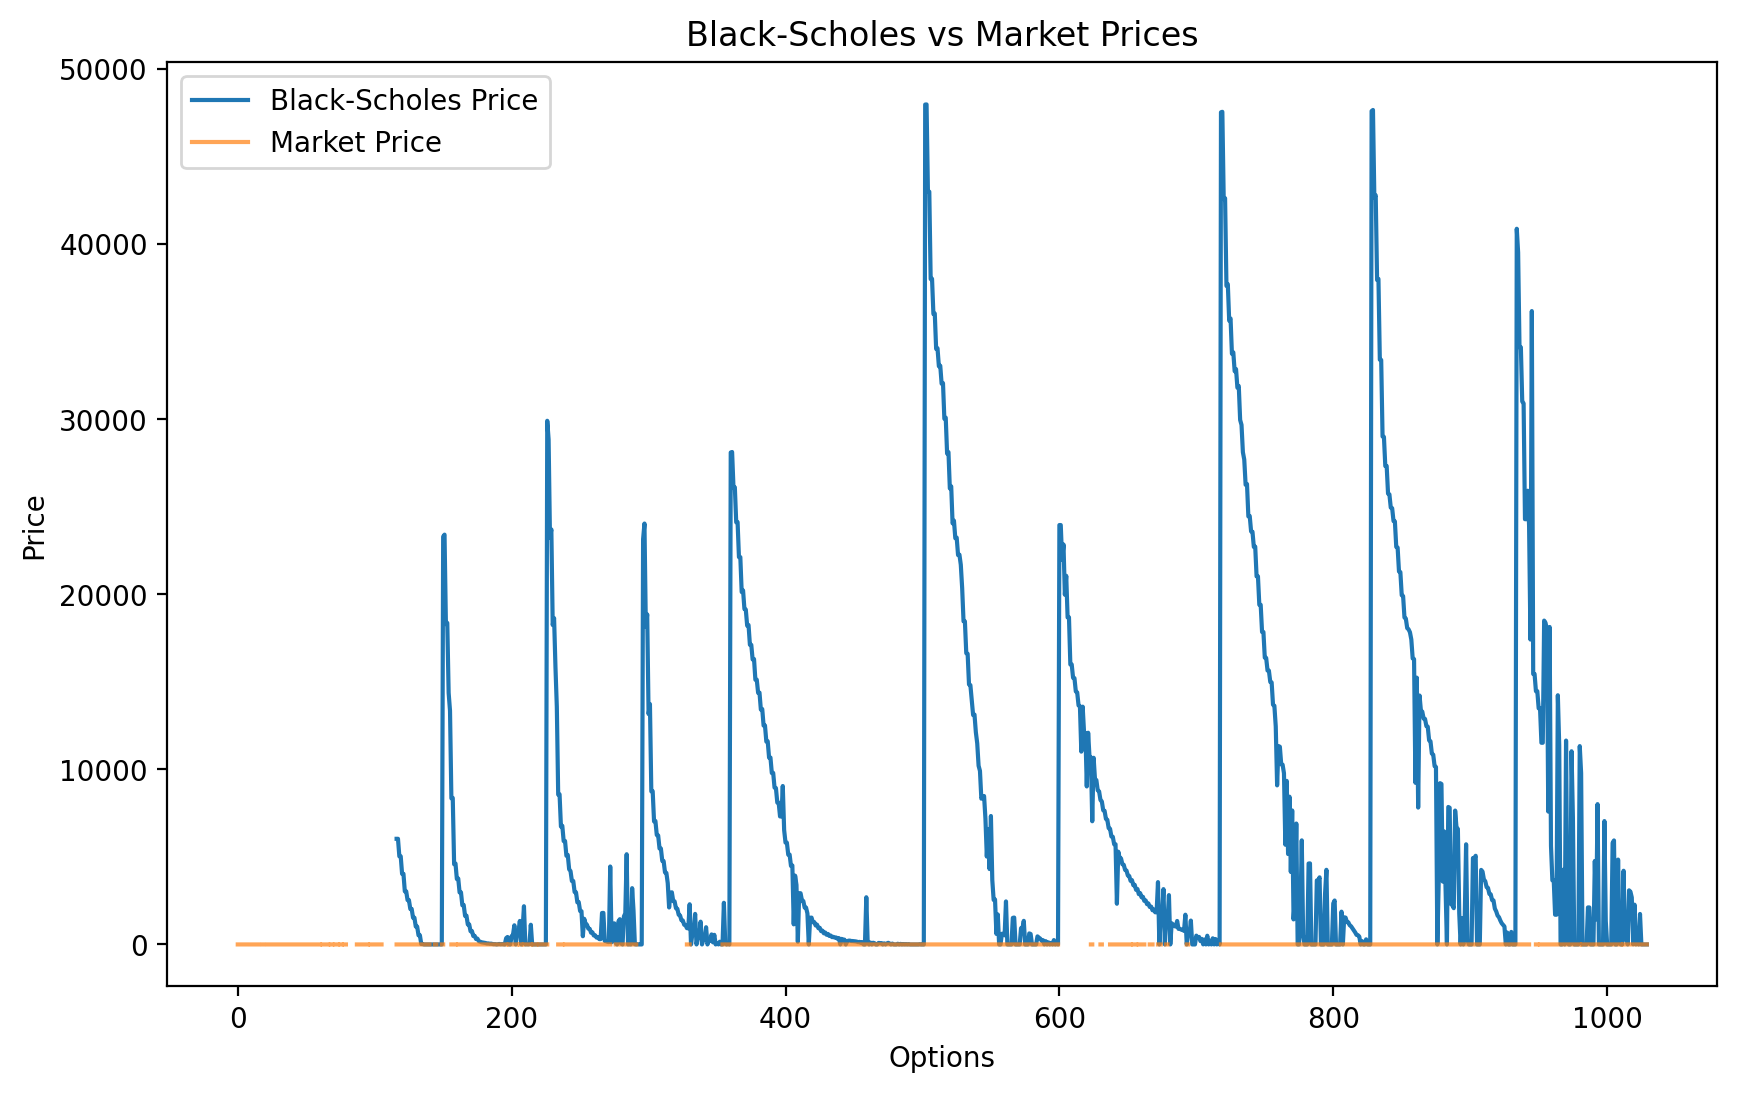

In [97]:
# Assume 'last_price' is the market price of the option
df['Market Price'] = df['last_price']  # or whatever the actual market price field is

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['BS Price'], label='Black-Scholes Price')
plt.plot(df['Market Price'], label='Market Price', alpha=0.7)
plt.title('Black-Scholes vs Market Prices')
plt.xlabel('Options')
plt.ylabel('Price')
plt.legend()
plt.show()


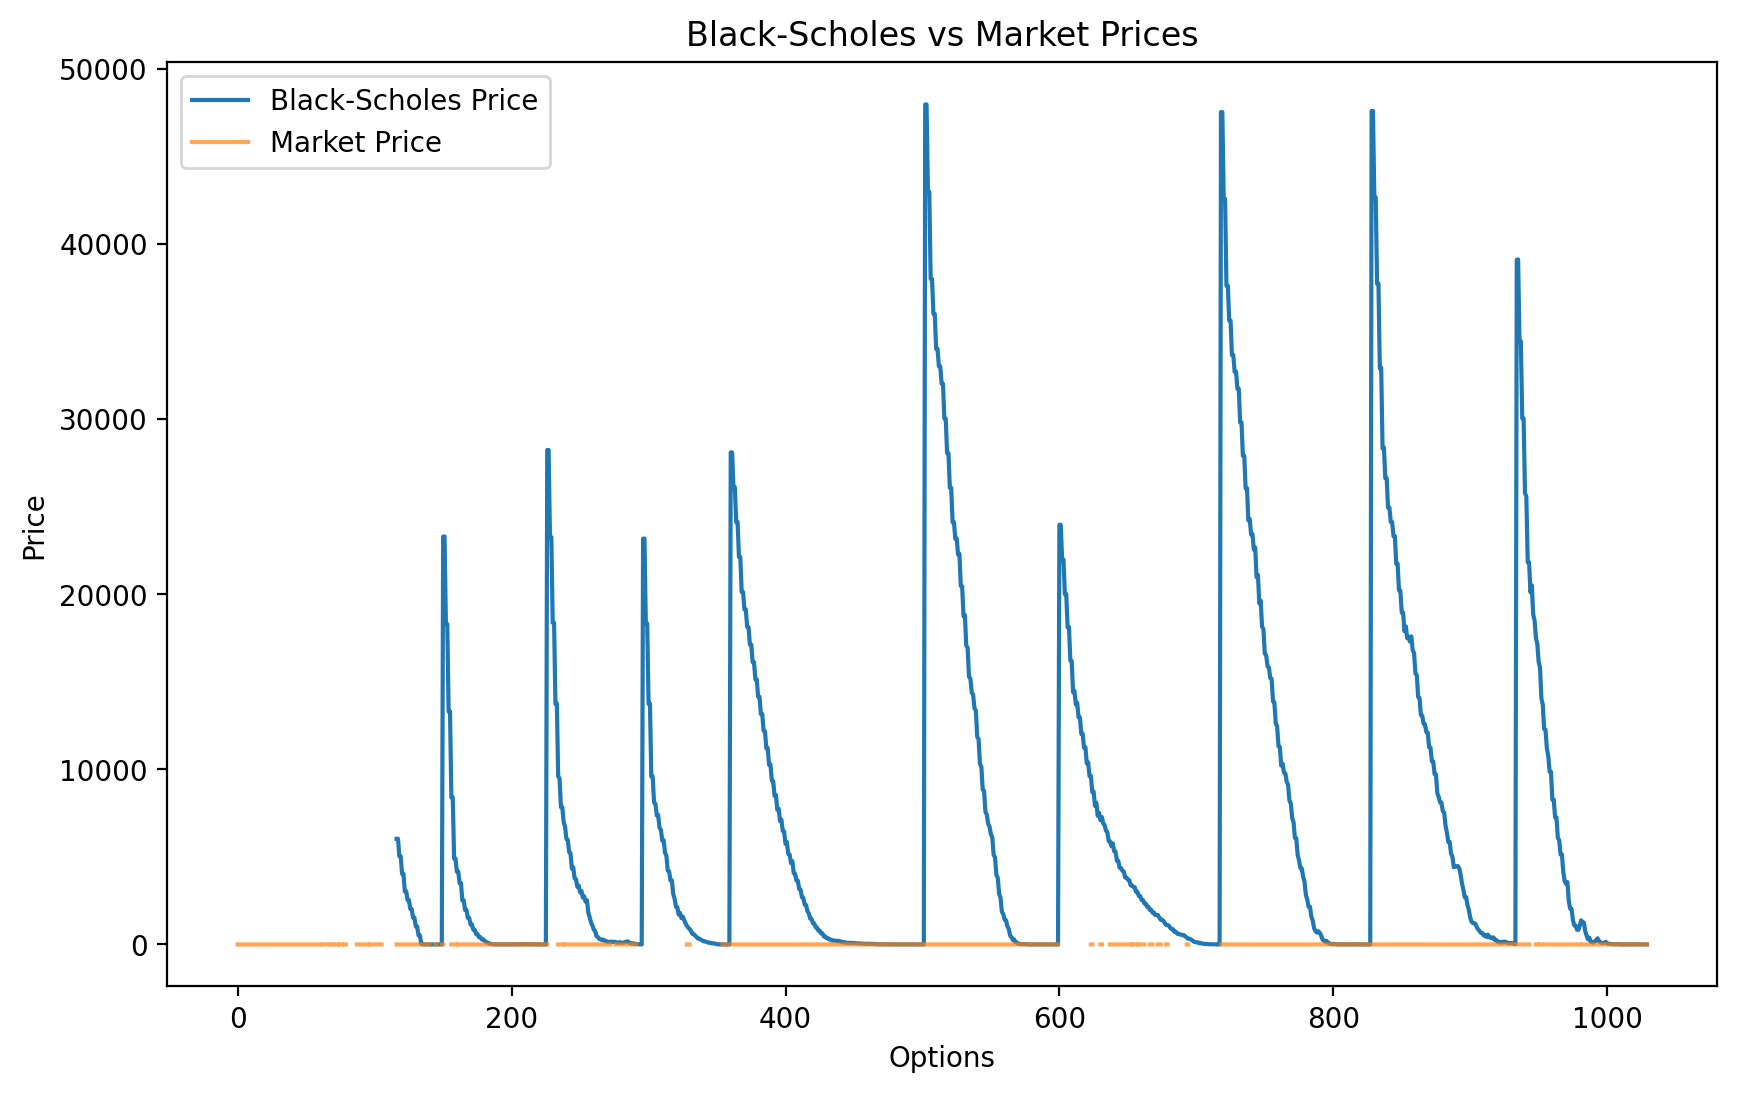

In [107]:
# Assume 'last_price' is the market price of the option
df['Market Price'] = df['last_price']  # or whatever the actual market price field is

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['BS Price_1'], label='Black-Scholes Price')
plt.plot(df['Market Price'], label='Market Price', alpha=0.7)
plt.title('Black-Scholes vs Market Prices')
plt.xlabel('Options')
plt.ylabel('Price')
plt.legend()
plt.show()


In [109]:
# Example: Calibrating volatility
from scipy.optimize import minimize

def mse(x, market_prices, S, K, T, r):
    sigma = x
    estimated_prices = [black_scholes_call(s, k, t, r, sigma) for s, k, t in zip(S, K, T)]
    return ((market_prices - estimated_prices) ** 2).mean()

initial_guess = 0.5
result = minimize(mse, initial_guess, args=(df['Market Price'].values, df['underlying_price'].values, df['Strike Price'].values, df['Time to Expiration'].values, risk_free_rate))
optimal_sigma = result.x


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\4222010145.py:5: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\4222010145.py:6: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\4222010145.py:5: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [110]:
from scipy.optimize import minimize

# Define the Black-Scholes call pricing function
from scipy.stats import norm
import numpy as np

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Function to calculate mean squared error between theoretical and market prices
def mse(sigma, market_prices, S, K, T, r):
    estimated_prices = [black_scholes_call(s, k, t, r, sigma) for s, k, t in zip(S, K, T)]
    return np.mean((np.array(market_prices) - np.array(estimated_prices)) ** 2)

# Example data preparation: Assume df contains the relevant data
market_prices = df['Market Price'].values
underlying_prices = df['underlying_price'].values
strike_prices = df['Strike Price'].values
times_to_expiration = df['Time to Expiration'].values
risk_free_rate = 0.02  # Example rate, adjust according to your needs

# Optimize for the best sigma (volatility) using minimize
initial_guess = 0.5  # Initial guess for volatility
result = minimize(mse, initial_guess, args=(market_prices, underlying_prices, strike_prices, times_to_expiration, risk_free_rate))
optimal_sigma = result.x[0]

print(f"The optimal volatility (sigma) is: {optimal_sigma}")


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\2683938550.py:8: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\2683938550.py:9: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_10268\2683938550.py:8: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


The optimal volatility (sigma) is: 0.5
